<a href="https://colab.research.google.com/github/Kiran771/AIvsHumanWrittenText/blob/main/DistilBERT_aivshumanwrittentext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install DistilBERT dependencies

In [ ]:
!pip install transformers torch datasets scikit-learn

In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix,roc_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification,EarlyStoppingCallback
from transformers import Trainer, TrainingArguments

In [ ]:
# load dataset
df=pd.read_csv('/content/AI-Human.csv')

In [ ]:
df.head()

,title,abstract,label
0,Epigenetic inheritance of circadian period in ...,\n\nThis study focuses on the epigenetic inher...,1
1,Pediatric Airway Stent Designed to Facilitate ...,Objective: The goal was to develop a pediatric...,0
2,Infection prevention and control in paediatric...,Transmission of infection in the paediatric of...,0
3,"Correlation between thyroid function, testoste...",STUDY DESIGN: Prospective case series. OBJECTI...,0
4,Natural intertypic and intratypic recombinants...,\n\nThis study aims to analyze the recombinant...,1


In [ ]:
# combine title and abstract as one in text column
df['text'] = df['title'].fillna('') + ' [SEP] ' + df['abstract'].fillna('')

In [ ]:
df['text']

,text
0,Epigenetic inheritance of circadian period in ...
1,Pediatric Airway Stent Designed to Facilitate ...
2,Infection prevention and control in paediatric...
3,"Correlation between thyroid function, testoste..."
4,Natural intertypic and intratypic recombinants...
...,...
28657,The E/e’ Ratio—Role in Risk Stratification of ...
28658,Income-Generating Processes of Free Web-Based ...
28659,Pathways of Photosynthesis in Non-Leaf Tissues...
28660,Complex Carbohydrates in Drug Development [SEP...


In [ ]:
# Find unique labels
print(df['label'].unique())


[1 0]


In [ ]:
# Minimal text preprocessing for DistilBERT: removes HTML tags, replaces URLs/emails with tokens, normalizes whitespace
def preprocess_for_distilbert(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http[s]?://\S+', ' [URL] ', text)
    text = re.sub(r'\S+@\S+', ' [EMAIL] ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Apply preprocessing to all text data
df['text'] = df['text'].apply(preprocess_for_distilbert)

# Convert DataFrame columns to lists for model input
texts = df['text'].tolist()
labels = df['label'].astype(int).tolist()

In [ ]:
# Split data into train (64%), validation (16%), and test (20%) sets with stratification
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.2, random_state=42, stratify=train_val_labels
)

In [ ]:
# load DistilBert For tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# convert lable to tensor
train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

In [ ]:
# Train set
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

# Validation set
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

# Test set
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)


In [ ]:
# Custom PyTorch Dataset class for DistilBERT tokenized inputs
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Create PyTorch Dataset objects for train, validation, and test sets
train_dataset = TextDataset(train_encodings, train_labels_tensor)
val_dataset   = TextDataset(val_encodings, val_labels_tensor)
test_dataset  = TextDataset(test_encodings, test_labels_tensor)


In [ ]:
# Load pretrained DistilBERT model for AI and Human text classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Configure training hyperparameters for DistilBERT fine-tuning
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=200,
     # weight_decay=0.01,
    # weight_decay=0.2,
    # learning_rate=5e-6,
    weight_decay=0.05,
    learning_rate=2e-5,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
     fp16=True,
    seed=42
)

In [ ]:
# Compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Initialize Trainer with model, datasets, and early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.001
    )]

)

In [ ]:
# Train the DistilBERT model
trainer.train()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.005100,0.007083,0.997601,0.999125,0.996075,0.997598
2,0.011600,0.006303,0.998692,0.997390,1.000000,0.998693
3,0.000100,0.005462,0.998692,0.998257,0.999128,0.998692


/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommende

TrainOutput(global_step=3441, training_loss=0.021493345331029836, metrics={'train_runtime': 784.643, 'train_samples_per_second': 70.133, 'train_steps_per_second': 4.385, 'total_flos': 7289548480641024.0, 'train_loss': 0.021493345331029836, 'epoch': 3.0})

In [ ]:
# Evaluate model performance on validation set
results = trainer.evaluate()

/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
# Display validation results
print(f"\nValidation Results:")
print(f"Accuracy:  {results['eval_accuracy']:.4f}")
print(f"F1 Score:  {results['eval_f1']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall:    {results['eval_recall']:.4f}")


Validation Results:
Accuracy:  0.9987
F1 Score:  0.9987
Precision: 0.9983
Recall:    0.9991


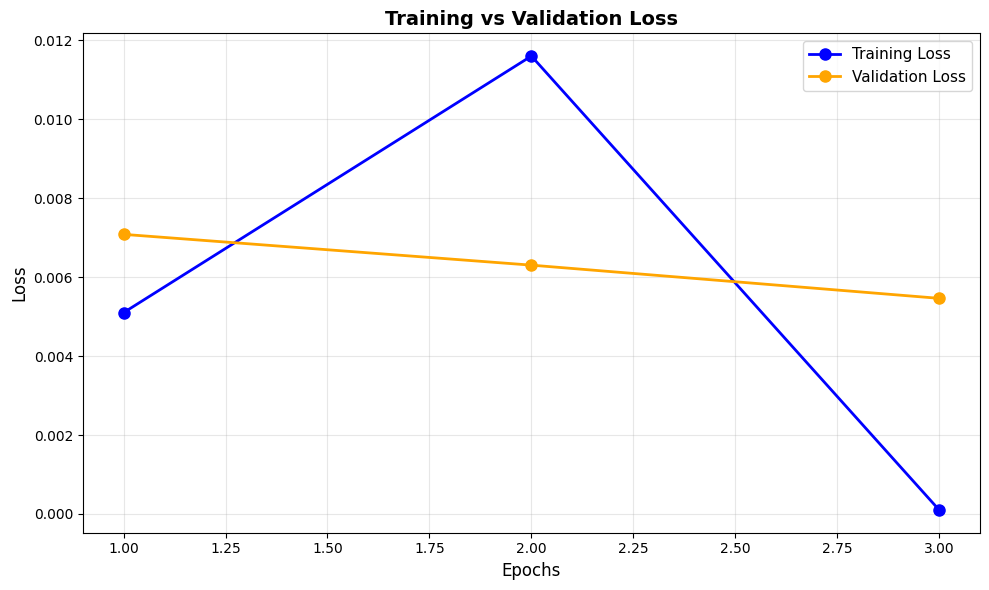

In [ ]:
# Plot trainiing and validation loss
epochs = [1, 2, 3]
train_loss = [0.005100, 0.011600, 0.000100]
val_loss = [0.007083,0.006303,0.005462]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss', linewidth=2, markersize=8)
plt.plot(epochs, val_loss, 'o-', color='orange', label='Validation Loss', linewidth=2, markersize=8)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
# Evaluate the model performance on test dataset
test_result = trainer.evaluate(test_dataset)

/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
# Display test results
print(f"\nTest Results:")
print(f"Accuracy:  {test_result['eval_accuracy']:.4f}")
print(f"F1 Score:  {test_result['eval_f1']:.4f}")
print(f"Precision: {test_result['eval_precision']:.4f}")
print(f"Recall:    {test_result['eval_recall']:.4f}")


Test Results:
Accuracy:  0.9988
F1 Score:  0.9988
Precision: 0.9986
Recall:    0.9990


In [ ]:
# Model evaluation on test dataset
preds_output = trainer.predict(test_dataset)
y_pred = preds_output.predictions.argmax(axis=1)
y_true = preds_output.label_ids


/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
cm = confusion_matrix(y_true, y_pred)

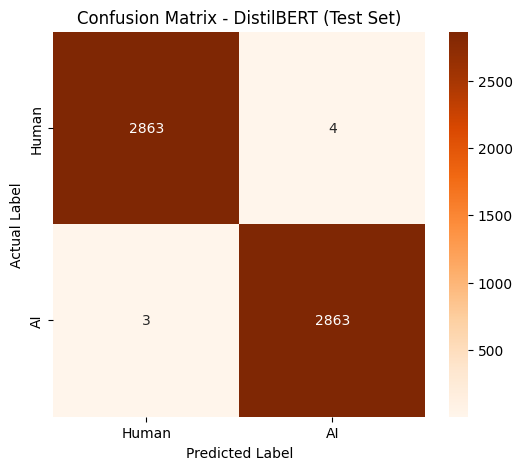

In [ ]:
# plot confusion matrix for test set
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Human','AI'], yticklabels=['Human','AI'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - DistilBERT (Test Set)')
plt.show()

/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


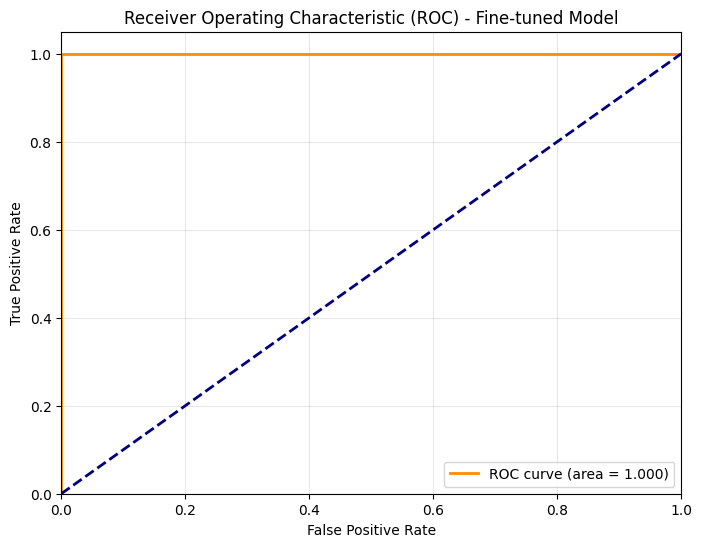

In [ ]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
probs = nn.functional.softmax(torch.from_numpy(logits), dim=-1)
pos_probs = probs[:, 1].numpy()
fpr, tpr, thresholds = roc_curve(labels, pos_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Fine-tuned Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Test Samples

In [ ]:
test_samples = [
    "study analyzed how influenza infection affects respiratory activity in human cells.",

    "This paper presents a comprehensive study on viral infections and their associated health risks. The research findings indicate that disease progression in patients is closely related to cellular response mechanisms.",

    "Clinical results show that patients with viral infections respond well to this treatment.",

    "The analysis provides insights into the potential mechanisms associated with disease development. This research explores novel strategies for understanding viral infection outcomes in clinical settings.",

    "Researchers observed a high expression of protein in lung cells of mice induced with the virus.",

    "This article presents evidence from multiple studies examining the relationship between viral infections and immune response. The findings suggest that disease outcomes are significantly associated with patient characteristics and treatment strategies.",

    "The data from these studies associated the specific RNA gene with immune response in patients.",

    "This research paper investigates potential therapeutic strategies for managing viral diseases. The study provides comprehensive analysis of clinical outcomes and presents novel findings regarding infection control in healthcare settings.",

    "Our analysis of viral proteins provides new insights into disease development and health risk.",

    "This paper examines the relationship between viral infection and cellular response in patients. The research presents findings that demonstrate potential associations between disease progression and immune function, providing evidence for novel therapeutic strategies.",

    "Influenza virus causes respiratory infections in patients with weakened immune systems.",

    "In conclusion, this study provides important evidence regarding the potential impact of viral infections on patient health outcomes, suggesting that further research is needed to fully understand the associated risk factors."
]


In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set model to evaluation mode and move to device
model.eval()
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Result of DistilBERT on sample data

In [ ]:
predictions = []

# Loop through samples
for text in test_samples:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    predictions.append(pred)

# Show results
print("Predictions (0=Human, 1=AI):")
print(predictions)

Predictions (0=Human, 1=AI):
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
